In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import seaborn as sns

(768, 9)
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Outcome
0    500
1    268
Name: count, dtype: int64
Missing counts after zero->NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Mutual information ranking:
Glucose                     0.117733
BMI                         0.081040
Pregnancies                 0.060985
Age                         0.051395
DiabetesPedigreeFunction    0.014590
Insulin                     0.012804
SkinThickness               0.012372
BloodPressure               0.001763
dtype: float64
Selected features: ['Glucose', 'BMI', 'Pregnancies', 'Age', 'DiabetesPedigreeFunction', 'Insulin']
SVM CV 

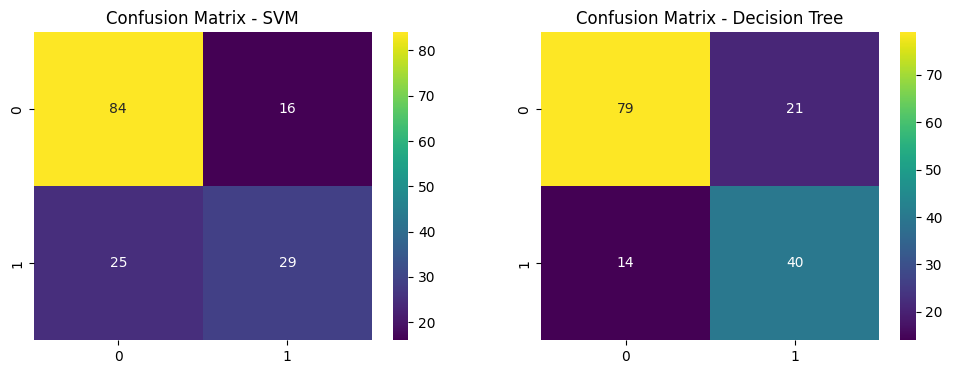

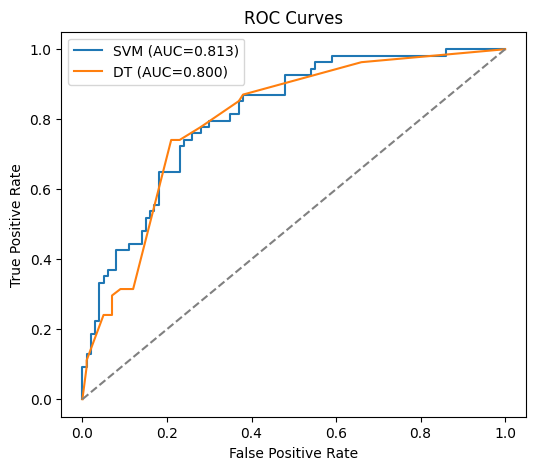

Permutation importance (SVM):
 Glucose                     0.052273
Insulin                     0.014610
DiabetesPedigreeFunction    0.005195
Pregnancies                 0.004545
Age                         0.000974
BMI                         0.000649
dtype: float64
Permutation importance (DT):
 Glucose                     0.106494
Age                         0.086364
BMI                         0.066234
Insulin                     0.000000
Pregnancies                -0.001948
DiabetesPedigreeFunction   -0.006169
dtype: float64


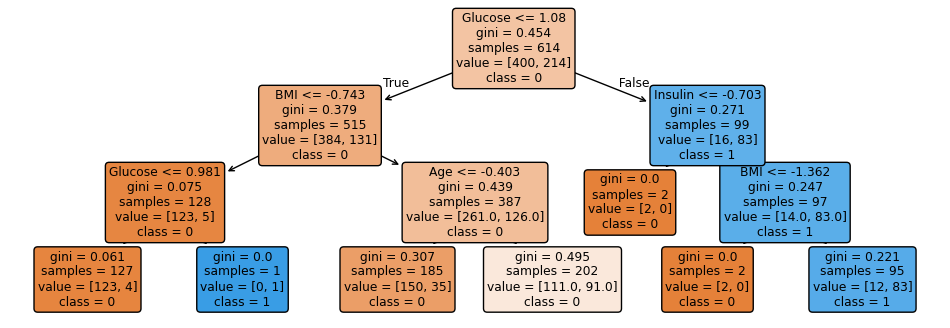

In [ ]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
print(df.columns)
print(df['Outcome'].value_counts())

#We handle missing value Treat zeros as missing for physiologically-impossible fields
zero_as_na_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in zero_as_na_cols:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

print("Missing counts after zero->NaN:")
print(df.isnull().sum())

# Features / target
target = 'Outcome'
X = df.drop(columns=[target])
y = df[target]

# EDA is optional, histograms, correlation givs more accurate visualization

# I Impute (median) and scale over here.
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns)

#  Feature ranking
mi = mutual_info_classif(X_imp, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual information ranking:")
print(mi_series)

# Select top features (or use full set).
selected_features = mi_series.head(6).index.tolist()
print("Selected features:", selected_features)

X_sel = X_scaled[selected_features]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)

# Cross-validated baseline (optional)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
svm_base = SVC(kernel='rbf', probability=True, random_state=42)
dt_base = DecisionTreeClassifier(random_state=42)
print("SVM CV acc:", cross_val_score(svm_base, X_sel, y, cv=cv, scoring='accuracy').mean())
print("DT  CV acc:", cross_val_score(dt_base, X_sel, y, cv=cv, scoring='accuracy').mean())

# Small GridSearch for tuning,modest grids to save time.
svm_params = {'C':[0.1,1,10], 'gamma':['scale', 0.1]}
dt_params = {'max_depth':[3,5,7,None], 'min_samples_leaf':[1,3,5]}

svm_gs = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42), svm_params, cv=cv, scoring='roc_auc', n_jobs=-1)
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=cv, scoring='roc_auc', n_jobs=-1)

svm_gs.fit(X_train, y_train)
dt_gs.fit(X_train, y_train)
best_svm = svm_gs.best_estimator_
best_dt  = dt_gs.best_estimator_
print("Best SVM params:", svm_gs.best_params_)
print("Best DT  params:", dt_gs.best_params_)

# Evaluate on test set
def evaluate_model(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    y_pred_tr = model.predict(Xtr)
    y_pred_te = model.predict(Xte)
    try:
        y_prob_te = model.predict_proba(Xte)[:,1]
    except:
        try:
            y_prob_te = model.decision_function(Xte)
        except:
            y_prob_te = None
    res = {
        'train_acc': accuracy_score(ytr, y_pred_tr),
        'test_acc': accuracy_score(yte, y_pred_te),
        'train_f1': f1_score(ytr, y_pred_tr),
        'test_f1': f1_score(yte, y_pred_te),
        'precision': precision_score(yte, y_pred_te),
        'recall': recall_score(yte, y_pred_te),
        'roc_auc': roc_auc_score(yte, y_prob_te) if y_prob_te is not None else None,
        'confusion_matrix': confusion_matrix(yte, y_pred_te),
        'report': classification_report(yte, y_pred_te, zero_division=0)
    }
    return res, y_prob_te, y_pred_te

svm_res, svm_prob, svm_pred = evaluate_model(best_svm, X_train, X_test, y_train, y_test)
dt_res,  dt_prob,  dt_pred  = evaluate_model(best_dt,  X_train, X_test, y_train, y_test)

print("SVM results:", svm_res)
print("DT  results:", dt_res)

# Confusion matrix & ROC plot
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(svm_res['confusion_matrix'], annot=True, fmt="d", ax=axes[0], cmap='viridis')
axes[0].set_title('Confusion Matrix - SVM')
sns.heatmap(dt_res['confusion_matrix'], annot=True, fmt="d", ax=axes[1], cmap='viridis')
axes[1].set_title('Confusion Matrix - Decision Tree')
plt.show()

plt.figure(figsize=(6,5))
if svm_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, svm_prob)
    plt.plot(fpr, tpr, label=f"SVM (AUC={svm_res['roc_auc']:.3f})")
if dt_prob is not None:
    fpr2, tpr2, _ = roc_curve(y_test, dt_prob)
    plt.plot(fpr2, tpr2, label=f"DT (AUC={dt_res['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend(); plt.title('ROC Curves')
plt.show()

# Simple feature importance via permutation (for explainability)
perm_svm = permutation_importance(best_svm, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_dt  = permutation_importance(best_dt,  X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)

perm_svm_series = pd.Series(perm_svm.importances_mean, index=X_sel.columns).sort_values(ascending=False)
perm_dt_series  = pd.Series(perm_dt.importances_mean,  index=X_sel.columns).sort_values(ascending=False)
print("Permutation importance (SVM):\n", perm_svm_series)
print("Permutation importance (DT):\n", perm_dt_series)

# visualize a small tree for readability
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
small_tree.fit(X_train, y_train)
plt.figure(figsize=(12,4))
plot_tree(small_tree, feature_names=X_sel.columns, class_names=['0','1'], filled=True, rounded=True)
plt.show()